### PSIS: Pareto-smoothed Importance sampling

- ref:  https://arxiv.org/abs/1507.02646
- code cloned from: https://github.com/avehtari/PSIS
- Notebook contains simple examples exploring PSIS vs SNIS
- Example under "Larger experiment" is the same as in the paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# append path to PSIS, cloned from https://github.com/avehtari/PSIS
sys.path.append("/Users/zizi/code/SML_VI")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as dist


In [4]:
# Self-normalised omportance sampling 
def SNIS_sample(proposal, target_density, N, normalise_weights=True):
    """
        proposal:  should have .sample and .log_prob methods (torch.distributions would do)
        target_density: should have .log_prob method
        returns: (log-weights, samples)
    """
    samples = proposal.sample(N)
    log_weights = target_density.log_prob(samples) - proposal.log_prob(samples)
    if normalise_weights:
        log_weights = log_weights - torch.logsumexp(log_weights, dim=-1)
    return log_weights.numpy(), samples.numpy()


def IS_sample(proposal, target_density, N):
    return SNIS_sample(proposal, target_density, N, normalise_weights=False)


def SNIS_approximate(samples, log_weights, fn=lambda x: x):
    # weights add up to 1
    weights = np.exp(log_weights)
    return (fn(samples)*weights).sum()


def IS_approximate(samples, log_weights, fn=lambda x: x):
    # weights aren't scaled
    weights = np.exp(log_weights)
    return (fn(samples)*weights).mean()


#### Simple example: sample normal with mean=1, var=2, from Normal(0, 1)

In [5]:
target = dist.Normal(loc=1, scale=np.sqrt(2))
proposal = dist.Normal(0, 1)

In [6]:
torch.manual_seed(42)
weights, samples = IS_sample(proposal, target, torch.Size([10000]))

print("Importance Sampling--- \nMean and standard deviation estimates:")
mu_est = IS_approximate(samples, weights)
var_est = IS_approximate(samples, weights, fn=lambda x: x**2) - mu_est**2
print(f"{mu_est :.3f}, {np.sqrt(var_est) :.3f}; true params 1, {np.sqrt(2) :.3f}")

Importance Sampling--- 
Mean and standard deviation estimates:
1.017, 1.417; true params 1, 1.414


In [7]:
torch.manual_seed(42)
weights, samples = SNIS_sample(proposal, target, torch.Size([10000]))

print("SNIS--- \nMean and standard deviation estimates:")
mu_est = SNIS_approximate(samples, weights)
var_est = SNIS_approximate(samples, weights, fn=lambda x: x**2) - mu_est**2
print(f"{mu_est :.3f}, {np.sqrt(var_est) :.3f}; true params 1, {np.sqrt(2) :.3f}")

SNIS--- 
Mean and standard deviation estimates:
1.012, 1.415; true params 1, 1.414


-----------

SNIS fails in low dimensions when target has heavier tails than the proposal. Example?

In [8]:
# https://arxiv.org/abs/1507.02646; 
# code cloned from https://github.com/avehtari/PSIS
from PSIS.py import psis

In [9]:
target = dist.Exponential(1)
# Infinite variance for theta > 2 [Robert, Casella]
proposal1 = dist.Exponential(1)
proposal2 = dist.Exponential(2)
proposal10 = dist.Exponential(10)

In [10]:
n_samples = 10000
torch.manual_seed(12)
lw2, samples2 = SNIS_sample(proposal2, target, torch.Size([n_samples]))
torch.manual_seed(12)
lw10, samples10 = SNIS_sample(proposal10, target, torch.Size([n_samples]))

psis_lw2, k2 = psis.psislw(lw2)
psis_lw10, k10 = psis.psislw(lw10)

print(f"Kappa estimates: {k2 :.2f}, {k10 :.2f}")
print(f"Samples means (equal to the means of the proposals): {samples2.mean() :.2f}, {samples10.mean() :.2f}") 

Kappa estimates: 0.42, 0.80
Samples means (equal to the means of the proposals): 0.50, 0.10


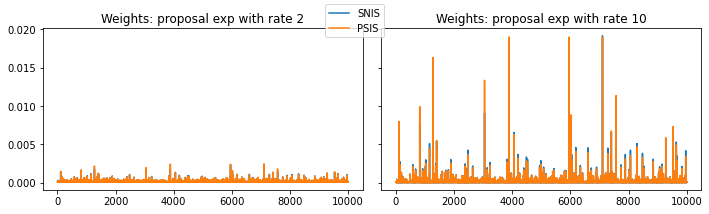

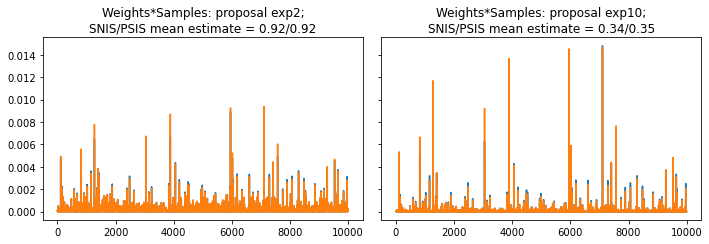

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
l, = ax[0].plot(np.exp(lw2)) 
m, = ax[0].plot(np.exp(psis_lw2)) 
ax[0].set_title("Weights: proposal exp with rate 2")
fig.legend( (l, m), ("SNIS", "PSIS"), loc="upper center")

ax[1].plot(np.exp(lw10))
ax[1].plot(np.exp(psis_lw10))
ax[1].set_title("Weights: proposal exp with rate 10")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), sharex=True, sharey=True)
ax[0].plot(np.exp(lw2)*samples2) 
ax[0].plot(np.exp(psis_lw2)*samples2) 
ax[0].set_title(
    f"Weights*Samples: proposal exp2;\n" 
    f"SNIS/PSIS mean estimate = {(np.exp(lw2)*samples2).sum() :.2f}/{(np.exp(psis_lw2)*samples2).sum() :.2f}"
)

ax[1].plot(np.exp(lw10)*samples10)
ax[1].plot(np.exp(psis_lw10)*samples10)
ax[1].set_title(
    f"Weights*Samples: proposal exp10;\n" 
    f"SNIS/PSIS mean estimate = {(np.exp(lw10)*samples10).sum() :.2f}/{(np.exp(psis_lw10)*samples10).sum() :.2f}")
plt.tight_layout()
plt.show()


In [12]:
print("Rate=2 SNIS mean and standard deviation estimates")
mu_est_SNIS = SNIS_approximate(samples2, lw2)
var_est_SNIS = SNIS_approximate(samples2, lw2, fn=lambda x: x**2) - mu_est_SNIS**2
print(f"{mu_est_SNIS :.3f}, {np.sqrt(var_est_SNIS) :.3f}")

print("Rate=2 PSIS mean and standard deviation estimates")
mu_est_PSIS = SNIS_approximate(samples2, psis_lw2)
var_est_PSIS = SNIS_approximate(samples2, psis_lw2, fn=lambda x: x**2) - mu_est_PSIS**2
print(f"{mu_est_PSIS :.3f}, {np.sqrt(var_est_PSIS) :.3f}")

print("-----------")

print("Rate=10 SNIS mean and standard deviation estimates")
mu_est_SNIS10 = SNIS_approximate(samples10, lw10)
var_est_SNIS10 = SNIS_approximate(samples10, lw10, fn=lambda x: x**2) - mu_est_SNIS10**2
print(f"{mu_est_SNIS10 :.3f}, {np.sqrt(var_est_SNIS10) :.3f}")

print("Rate=10 PSIS mean and standard deviation estimates")
mu_est_PSIS10 = SNIS_approximate(samples10, psis_lw10)
var_est_PSIS10 = SNIS_approximate(samples10, psis_lw10, fn=lambda x: x**2) - mu_est_PSIS10**2
print(f"{mu_est_PSIS10 :.3f}, {np.sqrt(var_est_PSIS10) :.3f}")



Rate=2 SNIS mean and standard deviation estimates
0.921, 0.825
Rate=2 PSIS mean and standard deviation estimates
0.922, 0.828
-----------
Rate=10 SNIS mean and standard deviation estimates
0.341, 0.223
Rate=10 PSIS mean and standard deviation estimates
0.347, 0.227


----------------------

### Larger experiment

In [13]:
def run(n_samples=500, n_runs=100, rates=[1, 2, 5, 10]):
    target = dist.Exponential(1)
    is_means = np.zeros((n_runs, len(rates)))
    snis_means = np.zeros((n_runs, len(rates)))
    psis_means = np.zeros((n_runs, len(rates)))
    
    for i in range(n_runs):
        for j, rate in enumerate(rates):
            proposal = dist.Exponential(rate)
            
            is_lw, samples = IS_sample(proposal, target, torch.Size([n_samples]))
            is_mean = IS_approximate(samples, is_lw)

            snis_lw, samples = SNIS_sample(proposal, target, torch.Size([n_samples]))
            snis_mean = SNIS_approximate(samples, snis_lw)

            psis_lw, kappa = psis.psislw(snis_lw)
            psis_mean = SNIS_approximate(samples, psis_lw)

            is_means[i, j] = is_mean
            snis_means[i, j] = snis_mean
            psis_means[i, j] = psis_mean
            
    is_means, snis_means, psis_means = [
        pd.DataFrame(x, columns=rates).reset_index() for x in (is_means, snis_means, psis_means)
    ]
    is_means["method"] = "IS"
    snis_means["method"] = "SNIS"
    psis_means["method"] = "PSIS"
    return pd.concat([is_means, snis_means, psis_means])


In [14]:
n_runs=100
torch.manual_seed(7)
res = run(n_samples=10000, n_runs=n_runs)
res = res.melt(id_vars=["method", "index"], var_name="rate", value_name="Mean Estimate")

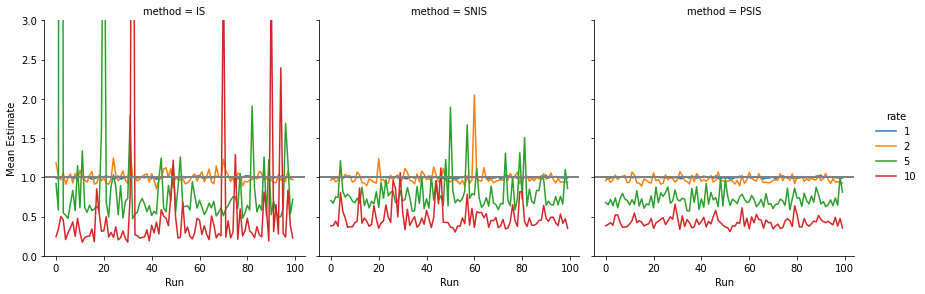

In [15]:
g = sns.FacetGrid(res, col="method", hue="rate", height=4, aspect=1)
g.map(plt.plot, "index", "Mean Estimate")
g.add_legend()
g.set(ylim=(0, 3)) # snipping y-axis!
g.map(plt.axhline, y=1, ls="-", c=".5")
g.set_ylabels("Mean Estimate")
g.set_xlabels("Run")
plt.show()

What about average estimates?
- Focus on SNIS vs PSIS -- indeed on average mean estimates are equally biased, but std is considerably lower in PSIS

In [16]:
res_g = res.groupby(["method", "rate"])
summary_stats = res_g.mean()
summary_stats["std"] = res_g.std().iloc[:, -1]
summary_stats

index  Mean Estimate       std
method rate                                
IS     1      49.5       0.999909  0.010787
       2      49.5       1.000804  0.078006
       5      49.5       1.258573  4.700753
       10     49.5       0.550730  1.082398
PSIS   1      49.5       0.998623  0.009684
       2      49.5       0.973292  0.041848
       5      49.5       0.718131  0.090372
       10     49.5       0.430618  0.064698
SNIS   1      49.5       0.998623  0.009684
       2      49.5       0.995035  0.120390
       5      49.5       0.795567  0.222486
       10     49.5       0.491950  0.161747

In [36]:
# def pareto_smoothing(log_weights):
#     ordered = np.sort(log_weights)
#     s = len(log_weights)
#     M = 3*np.sqrt(s) if s > 225 else s/5
#     M = int(M)
#     u_hat = ordered[M]
#     weights_above_M = np.exp(ordered[M:])
    
#     kappa, sigma = psis.gpdfitnew(weights_above_M)
#     return kappa, sigma
